# 2. Patch Extraction & Visualization

This notebook demonstrates how to extract patches from WSIs for training.

## The 4-Class Problem

We categorize patches into 4 classes based on their source and content:

| Class | Name | Description |
|-------|------|-------------|
| 0 | Normal from Normal | Normal tissue from slides without any tumor |
| 1 | Normal from Tumor | Normal tissue from slides that contain tumor elsewhere |
| 2 | Boundary | Tissue partially overlapping tumor regions (1-50%) |
| 3 | Pure Tumor | Tissue mostly inside tumor regions (>50%) |

## Two Visualization Styles

We provide two ways to visualize patch locations:

1. **Scatter plots** - Dots at patch centers (fast, good for overview)
2. **Grid rectangles** - Actual patch boundaries as squares (shows true coverage)

In [ ]:
# REMOVE THIS CODE ONCE WE@RE HAPPY ALL IS WORKING WELL: sys.path.insert() will work well once this all in repo
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/new_work/Projects/Camelyon16/camelyon16-pathology

!apt-get -y install openslide-tools
!pip -q install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/new_work/Projects/Camelyon16
config.py  LICENSE  notebooks  __pycache__  README.md  requirements.txt  src


In [ ]:
# Install dependencies (run in Colab)
!apt-get install -y openslide-tools
!pip install openslide-python boto3 shapely scikit-image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 1 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 1s (130 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.


In [ ]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import openslide

from config import DEFAULT_CONFIG
from src.data import download_file_from_s3, cleanup_file
from src.data.tissue_mask import get_tissue_mask, get_scaling_factors
from src.data.tumor_polygons import load_tumor_polygons, classify_patch, calculate_tumor_overlap
from src.data.patch_extraction import (
    sample_grid_coordinates,
    extract_patch,
    preprocess_patch
)
from src.visualization import (
    visualize_patches_scatter,
    visualize_patches_scatter_zoomed,
    visualize_patches_grid,
    find_zoom_region_by_coords,
    find_dense_tissue_region,
    compare_visualization_styles
)

## 2.1 Coordinate Sampling

We create a grid of patch coordinates over tissue regions.

**Key concept**: We work with coordinates, not pixels!
- Generate coordinates at thumbnail resolution (fast)
- Map to full resolution only when extracting patches

In [ ]:
# Download a tumor slide
S3_IMAGES = 's3://camelyon-dataset/CAMELYON16/images/'
S3_ANNOTATIONS = 's3://camelyon-dataset/CAMELYON16/annotations/'

slide_path = download_file_from_s3(S3_IMAGES, 'tumor_001.tif', '/tmp')
xml_path = download_file_from_s3(S3_ANNOTATIONS, 'tumor_001.xml', '/tmp')

slide = openslide.OpenSlide(slide_path)
print(f"Slide dimensions: {slide.dimensions}")

Slide dimensions: (97792, 221184)


In [ ]:
# Get tissue mask
mask = get_tissue_mask(slide)
print(f"Mask shape: {mask.shape}")
print(f"Tissue pixels: {mask.sum():,}")

# Sample coordinates with no overlap (stride = patch_size)
coords = sample_grid_coordinates(slide, mask, patch_size=224, stride=224)
print(f"\nPatch coordinates (no overlap): {len(coords):,}")

# Sample with 50% overlap (stride = patch_size/2)
coords_dense = sample_grid_coordinates(slide, mask, patch_size=224, stride=112)
print(f"Patch coordinates (50% overlap): {len(coords_dense):,}")

Mask shape: (512, 226)
Tissue pixels: 5,826

Patch coordinates (no overlap): 21,763
Patch coordinates (50% overlap): 86,778


## 2.2 Patch Classification

For tumor slides, we classify each patch based on tumor overlap.

In [ ]:
# Load tumor polygons
polygons = load_tumor_polygons(xml_path)
print(f"Tumor regions: {len(polygons)}")

# Classify each coordinate
print("\nClassifying patches (this may take a moment)...")

coords_by_class = {1: [], 2: [], 3: []}

for x, y in coords:
    label = classify_patch(x, y, polygons, patch_size=224)
    coords_by_class[label].append((x, y))

print(f"\nClass distribution:")
print(f"  Class 1 (Normal from tumor): {len(coords_by_class[1]):,}")
print(f"  Class 2 (Boundary): {len(coords_by_class[2]):,}")
print(f"  Class 3 (Pure tumor): {len(coords_by_class[3]):,}")

Tumor regions: 2

Classifying patches (this may take a moment)...

Class distribution:
  Class 1 (Normal from tumor): 21,458
  Class 2 (Boundary): 83
  Class 3 (Pure tumor): 222


## 2.3 Visualization Style 1: Scatter Plots (Patch Centers)

Fast visualization showing dots at each patch center. Good for overview.

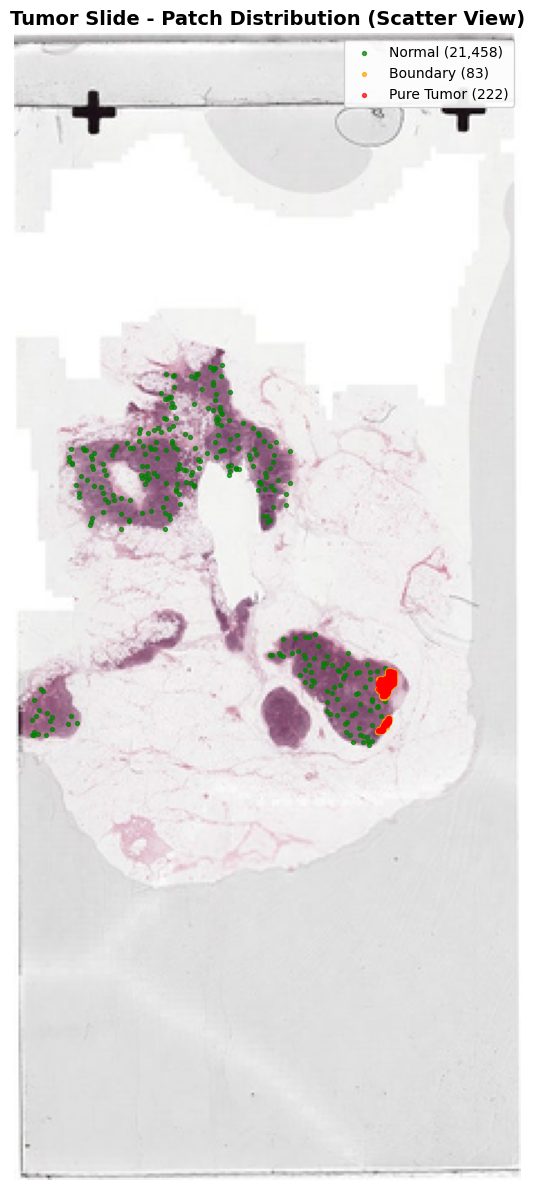

In [ ]:
# Full slide view with scatter points
visualize_patches_scatter(
    slide,
    coords_by_class,
    class_colors={1: 'green', 2: 'orange', 3: 'red'},
    class_labels={1: 'Normal', 2: 'Boundary', 3: 'Pure Tumor'},
    title='Tumor Slide - Patch Distribution (Scatter View)',
    max_points_per_class=300
)

In [ ]:
# Zoomed view centered on tumor region
zoom_region = find_zoom_region_by_coords(coords_by_class[3], region_size=10000)
print(f"Zoom region: {zoom_region}")

visualize_patches_scatter_zoomed(
    slide,
    coords_by_class,
    zoom_region,
    class_colors={1: 'green', 2: 'orange', 3: 'red'},
    class_labels={1: 'Normal', 2: 'Boundary', 3: 'Pure Tumor'},
    title='Zoomed Tumor Region (Scatter View)'
)

Output hidden; open in https://colab.research.google.com to view.

## 2.4 Visualization Style 2: Grid Rectangles (Patch Boundaries)

Shows the actual 224×224 patch boundaries as rectangles. Better for understanding true coverage.

In [ ]:
# Grid view showing actual patch boundaries
visualize_patches_grid(
    slide,
    coords_by_class,
    zoom_region,
    patch_size=224,
    class_colors={1: 'green', 2: 'orange', 3: 'red'},
    class_labels={1: 'Normal', 2: 'Boundary', 3: 'Pure Tumor'},
    title='Zoomed Tumor Region (Grid View)',
    linewidth=1.5
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Closer zoom to see individual patches clearly
small_zoom = find_zoom_region_by_coords(coords_by_class[3], region_size=4000)

visualize_patches_grid(
    slide,
    coords_by_class,
    small_zoom,
    patch_size=224,
    class_colors={1: 'green', 2: 'orange', 3: 'red'},
    class_labels={1: 'Normal', 2: 'Boundary', 3: 'Pure Tumor'},
    title='Close-up: Individual Patches Visible',
    linewidth=2.0
)

Output hidden; open in https://colab.research.google.com to view.

## 2.5 Compare Both Styles Side-by-Side

In [ ]:
# Compare both visualization styles
compare_visualization_styles(
    slide,
    coords_by_class,
    zoom_region,
    patch_size=224,
    title_prefix="Tumor Slide: "
)

Output hidden; open in https://colab.research.google.com to view.

## 2.6 Patch Extraction and Examples

Now let's extract some actual patches and visualize them.

In [ ]:
# Extract example patches from each class
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for row, class_id in enumerate([1, 2, 3]):
    class_coords = coords_by_class[class_id]

    # Get 5 random patches
    n_patches = min(5, len(class_coords))
    if n_patches == 0:
        continue

    idx = np.random.choice(len(class_coords), n_patches, replace=False)

    for col, i in enumerate(idx):
        x, y = class_coords[i]

        # Extract patch
        patch_pil = extract_patch(slide, x, y, patch_size=224)
        overlap = calculate_tumor_overlap(x, y, polygons, patch_size=224)

        axes[row, col].imshow(patch_pil)
        axes[row, col].set_title(f'Class {class_id}\n{overlap:.0%} overlap')
        axes[row, col].axis('off')

# Row labels
row_names = ['Normal from Tumor', 'Boundary', 'Pure Tumor']
for row, name in enumerate(row_names):
    axes[row, 0].set_ylabel(name, fontsize=12, rotation=0, ha='right', va='center')

plt.suptitle('Example Patches by Class', fontsize=14)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 2.7 Normal Slide Visualization

Let's also visualize patches from a normal slide (Class 0).

In [ ]:
# Close tumor slide first
slide.close()
cleanup_file(slide_path)
cleanup_file(xml_path)

# Download normal slide
normal_slide_path = download_file_from_s3(S3_IMAGES, 'normal_001.tif', '/tmp')
normal_slide = openslide.OpenSlide(normal_slide_path)
print(f"Normal slide dimensions: {normal_slide.dimensions}")

Normal slide dimensions: (97792, 221184)


In [ ]:
# Get tissue mask and sample coordinates
normal_mask = get_tissue_mask(normal_slide)
normal_coords = sample_grid_coordinates(normal_slide, normal_mask, patch_size=224, stride=224)
print(f"Normal patches: {len(normal_coords):,}")

# All patches from normal slide are class 0
normal_coords_by_class = {0: normal_coords}

Normal patches: 7,422


In [ ]:
# Find dense tissue region for zooming
normal_zoom = find_dense_tissue_region(normal_coords, region_size=10000)

# Scatter view
visualize_patches_scatter_zoomed(
    normal_slide,
    normal_coords_by_class,
    normal_zoom,
    class_colors={0: 'blue'},
    class_labels={0: 'Normal (Class 0)'},
    title='Normal Slide - Scatter View'
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Grid view
visualize_patches_grid(
    normal_slide,
    normal_coords_by_class,
    normal_zoom,
    patch_size=224,
    class_colors={0: 'green'},
    class_labels={0: 'Normal (Class 0)'},
    title='Normal Slide - Grid View',
    linewidth=1.0
)

Output hidden; open in https://colab.research.google.com to view.

## 2.8 Data Augmentation

We apply augmentation during training to increase diversity.

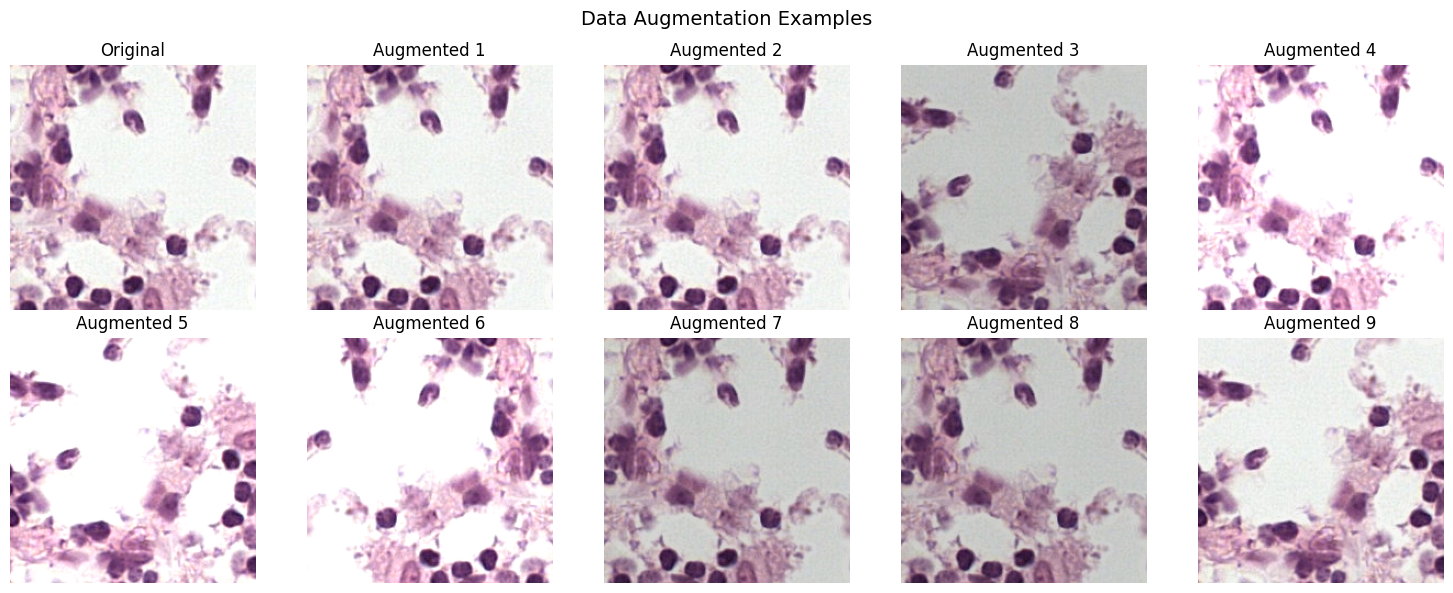

In [ ]:
# Show augmentation effects
x, y = normal_coords[0]
original = extract_patch(normal_slide, x, y, patch_size=224)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

axes[0, 0].imshow(original)
axes[0, 0].set_title('Original')

for i in range(1, 10):
    row, col = i // 5, i % 5
    augmented = preprocess_patch(original, augment=True)
    axes[row, col].imshow(augmented)
    axes[row, col].set_title(f'Augmented {i}')

for ax in axes.flat:
    ax.axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=14)
plt.tight_layout()
plt.show()

## 2.9 Cleanup

In [ ]:
normal_slide.close()
cleanup_file(normal_slide_path)
print("Cleaned up temporary files")

Cleaned up temporary files


## Summary

Key takeaways:

1. **Coordinate-based workflow** - Generate coordinates first, extract pixels only when needed
2. **Tumor overlap** - We classify patches by their overlap with tumor annotations
3. **Two visualization styles**:
   - **Scatter**: Fast, shows distribution at a glance
   - **Grid**: Shows actual patch boundaries, better for understanding coverage
4. **Dense sampling** - Smaller stride = more patches (useful for rare classes like boundary)
5. **Augmentation** - Flips, rotations, brightness jitter increase training diversity

Next: [03_model_training.ipynb](03_model_training.ipynb) - Train classification models